# Introducción a Redes Neuronales Convolucionales (CNN) con FashionMNIST

En esta notebook, implementaremos una Red Neuronal Convolucional (CNN) básica y aprenderemos conceptos fundamentales como convoluciones y pooling, utilizando el dataset [FashionMNIST](https://en.wikipedia.org/wiki/Fashion_MNIST). El objetivo principal es entender cómo las CNNs pueden ser aplicadas a problemas de clasificación de imágenes.

## Objetivos

1. **Entender los conceptos básicos de las Redes Neuronales Convolucionales (CNN)**, incluyendo convoluciones, capas de pooling y capas totalmente conectadas.
2. **Entrenar una CNN** en PyTorch utilizando el dataset FashionMNIST.
3. **Evaluar el rendimiento del modelo** utilizando métricas adecuadas y visualización de resultados.

In [2]:
!pip install torchinfo

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image, ImageReadMode

from torchinfo import summary

import os
from pathlib import Path

from utils import (
    train,
    model_calassification_report,
    show_tensor_image,
    show_tensor_images,
)

In [5]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 34

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")


Usando cpu
Usando 4


In [7]:

BATCH_SIZE = 128  # tamaño del batch

## Intro a CNNs

![Image](assets/cnn.png)


Las redes convolucionales (CNNs) son muy utilizadas en el campo de **computer vision**, es decir, en problemas relacionados con imágenes como clasificación, detección de objetos, segmentación, etc. Los dos conceptos clave en las CNNs son las **convoluciones** y el **pooling**. Debido a que los pixeles de una imagen tienen una relación espacial, las CNNs son capaces de capturar patrones locales en la imagen, como bordes, texturas, etc.

### Convoluciones

En el contexto de las CNNs, las convoluciones se aplican a una imagen de entrada y un filtro (kernel) para producir una imagen de salida. La operación de convolución se realiza deslizando el filtro sobre la imagen de entrada, multiplicando sus valores por los valores de los píxeles de la imagen y sumando el resultado.

![Image](https://d2l.ai/_images/correlation.svg)

Vamos a ver algunos ejemplos de convoluciones y como afectan a las imágenes. Para ellos vamos a utilizar la función [`torch.nn.functional.conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) de PyTorch.

In [8]:
input = torch.tensor([[0, 1, 2], [3, 4, 5], [6, 7, 8]], dtype=torch.float32)
kernel = torch.tensor([[0, 1], [2, 3]], dtype=torch.float32)

# para utilizar F.conv2d, necesitamos que las dimensiones de kernel sean [out_channels, in_channels, kernel_height, kernel_width]
# y las dimensiones de input sean [batch_size, in_channels, height, width]

input = input.reshape(1, 1, *input.shape)
kernel = kernel.reshape(1, 1, *kernel.shape)

F.conv2d(input, kernel)

tensor([[[[19., 25.],
          [37., 43.]]]])

Veamos un ejemplo de cómo se aplica una convolución a una imagen real. En este caso, vamos a definir filtros que ayudan a detectar bordes.

La función [read_image](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html) es una función auxiliar que lee una imagen de un archivo y la convierte en un tensor de PyTorch.

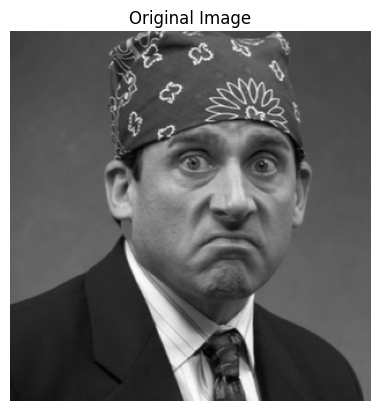

In [9]:
image = read_image(str(Path("assets") / "PrisonMike.png"), ImageReadMode.GRAY)

show_tensor_image(image, title="Original Image", vmin=0, vmax=255)

Definimos los siguientes filtros:

- `identity`: un filtro que no modifica la imagen.
- `edge`: detecta bordes.
- `sharpen`: resalta los bordes.
- `blur`: suaviza la imagen.

Forma de la imagen: torch.Size([1, 1, 320, 312])
Forma de los kernels: torch.Size([3, 1, 3, 3])
Forma de la salida: torch.Size([1, 3, 318, 310])


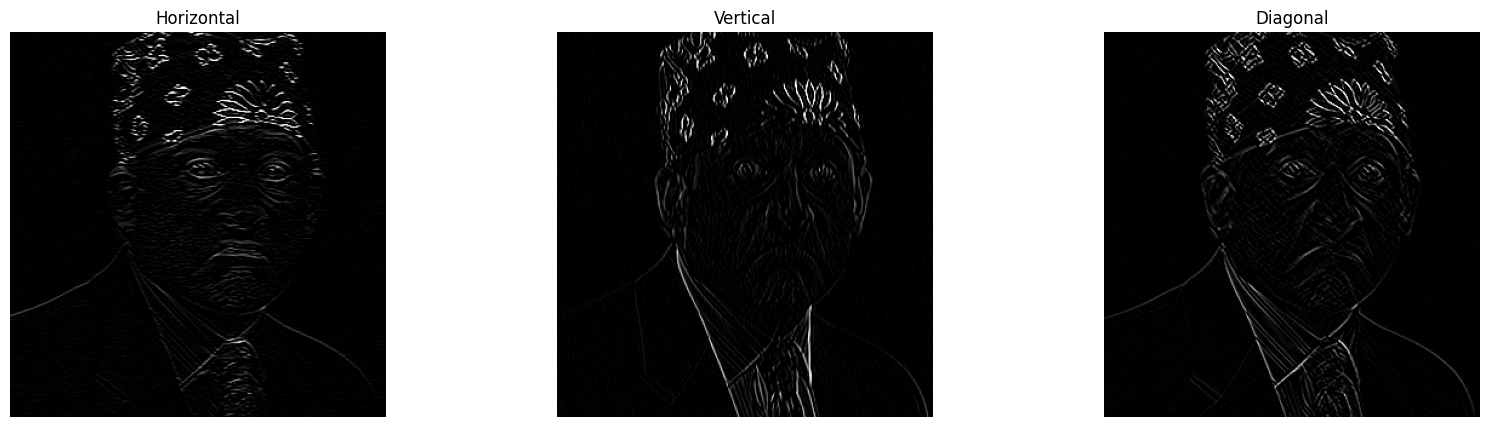

In [10]:
image_n = image.to(torch.float32)
image_batch = image_n.unsqueeze(0)

print("Forma de la imagen:", image_batch.shape)

horizontal_edge = torch.tensor([[[[-1, -1, -1],
                                  [ 2,  2,  2],
                                  [-1, -1, -1]]]], dtype=torch.float32)

vertical_edge = torch.tensor([[[[-1,  2, -1],
                                [-1,  2, -1],
                                [-1,  2, -1]]]], dtype=torch.float32)

diagonal_edge = torch.tensor([[[[2, -1, -1],
                                [-1, 2, -1],
                                [-1, -1, 2]]]], dtype=torch.float32)


# Apilar los kernels para aplicarlos todos a la vez
kernels = torch.cat([horizontal_edge, vertical_edge, diagonal_edge])
print("Forma de los kernels:", kernels.shape)

# Aplicar la convolución usando los kernels definidos
output = F.conv2d(image_batch, kernels)
print("Forma de la salida:", output.shape)

# Mostrar las imágenes resultantes
show_tensor_images(
    [output[0, i].unsqueeze(0) for i in range(output.shape[1])],
    titles=["Horizontal", "Vertical", "Diagonal"],
    figsize=(20, 5),
    vmin=0,
    vmax=255,
)

Forma de los kernels: torch.Size([5, 1, 3, 3])
Forma de la salida: torch.Size([1, 5, 318, 310])


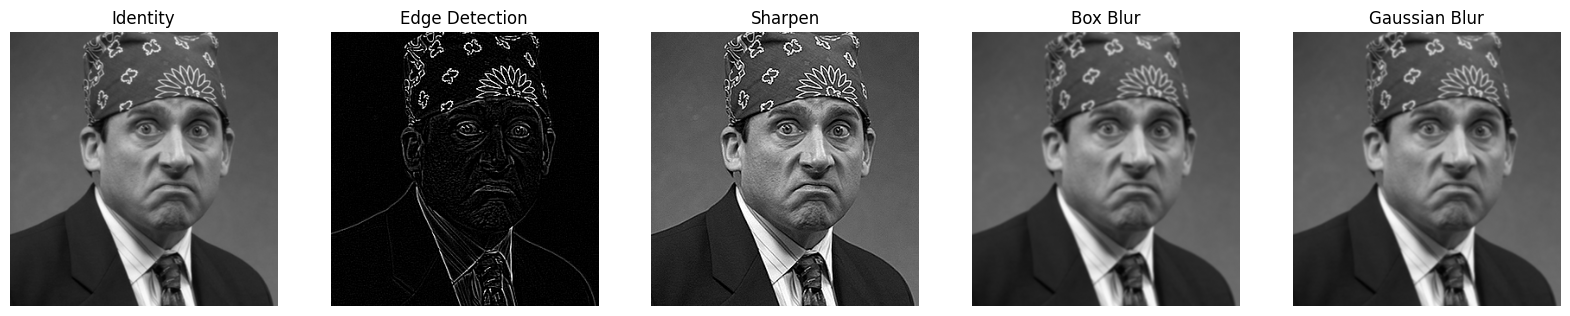

In [11]:
identity = torch.tensor([[[[0, 0, 0],
                           [0, 1, 0],
                           [0, 0, 0]]]], dtype=torch.float32)

edge = torch.tensor([[[[-1, -1, -1],
                       [-1, 8, -1],
                       [-1, -1, -1]]]], dtype=torch.float32)

sharpen = torch.tensor([[[[0, -1, 0],
                          [-1, 5, -1],
                          [0, -1, 0]]]], dtype=torch.float32)

box_blur = torch.tensor([[[[1, 1, 1],
                           [1, 1, 1],
                           [1, 1, 1]]]], dtype=torch.float32) / 9

gau_blur = torch.tensor([[[[1, 2, 1],
                           [2, 4, 2],
                           [1, 2, 1]]]], dtype=torch.float32) / 16


# Apilar los kernels para aplicarlos todos a la vez
kernels = torch.cat([identity, edge, sharpen, box_blur, gau_blur])
print("Forma de los kernels:", kernels.shape)

# Aplicar la convolución usando los kernels definidos
output = F.conv2d(image_batch, kernels)
print("Forma de la salida:", output.shape)

# Mostrar las imágenes resultantes
show_tensor_images(
    [output[0, i].unsqueeze(0) for i in range(output.shape[1])],
    titles=["Identity", "Edge Detection", "Sharpen", "Box Blur", "Gaussian Blur"],
    figsize=(20, 5),
    vmin=0,
    vmax=255,
)

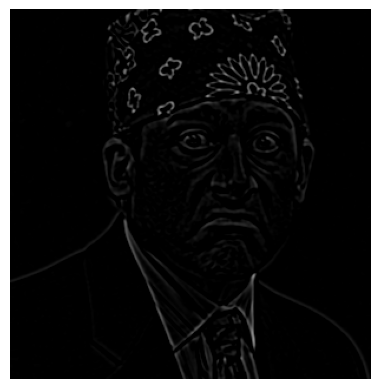

In [12]:
# podemos combinar
output = F.conv2d(image_batch, edge)
output = F.conv2d(output, box_blur)
output = F.conv2d(output, gau_blur)

show_tensor_image(output, vmin=0, vmax=255)

La buena noticia es que no necesitamos definir estos filtros manualmente, ya que PyTorch proporciona una función [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) que inicializa los pesos de los filtros de manera aleatoria y los entrena durante el proceso de aprendizaje.

Esto quiere decir que la red neuronal aprenderá automáticamente los filtros que son útiles para el problema en cuestión.

#### Otros parámetros de la convolución

Además de los filtros, las convoluciones tienen otros parámetros importantes:

- `stride`: paso de la convolución, es decir, cuántos píxeles se desplaza el filtro en cada paso.
- `padding`: relleno de la imagen, es decir, cuántos píxeles se añaden alrededor de la imagen. Muchas veces se utiliza para mantener el tamaño de la imagen de salida igual al de la imagen de entrada.
- `bias`: si se incluye un término de sesgo en la convolución.


Las dimensiones de salida se pueden calcular con la siguiente fórmula:

$$
\text{output\_size} = \frac{\text{input\_size} - \text{kernel\_size} + 2 \times \text{padding}}{\text{stride}} + 1
$$

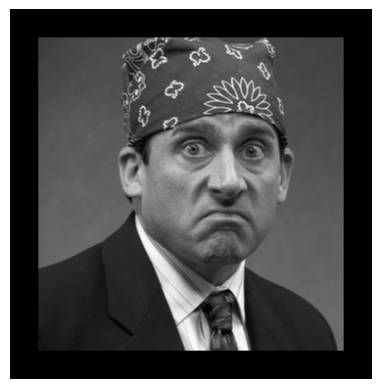

Shape de la imagen original: torch.Size([1, 1, 320, 312])
Shape de la imagen con padding: torch.Size([1, 1, 378, 370])


In [13]:
output = F.conv2d(image_batch, identity, padding=30)  # sumamos 30 pixeles de padding
show_tensor_image(output, vmin=0, vmax=255)

print(f"Shape de la imagen original: {image_batch.shape}")
print(f"Shape de la imagen con padding: {output.shape}")

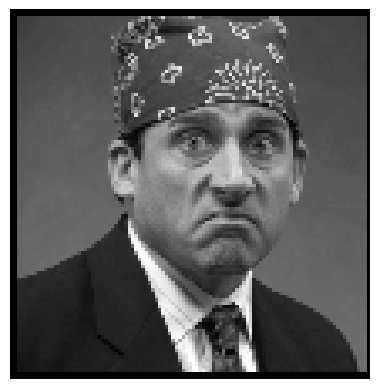

Shape de la imagen con stride: torch.Size([1, 1, 110, 107])


In [14]:
output = F.conv2d(image_batch, identity, stride=3, padding=5)
show_tensor_image(output)

print(f"Shape de la imagen con stride: {output.shape}")

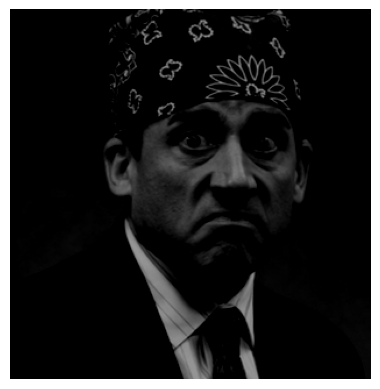

In [15]:
output = F.conv2d(image_batch, identity, bias=torch.tensor([-100.0]))
show_tensor_image(output, vmin=0, vmax=255)

### Pooling

El **Pooling** es una operación clave en las redes neuronales convolucionales (CNNs) que se utiliza para reducir las dimensiones espaciales (ancho y alto) de los mapas de características. Esto se logra resumiendo las características en regiones específicas de la imagen de entrada. El pooling ayuda a disminuir la cantidad de parámetros y el costo computacional, y también proporciona cierta invariancia a las traslaciones y deformaciones en la entrada.

> Cabe destacar que el pooling no tiene parámetros entrenables, ya que simplemente aplica una función fija a una región de la imagen.

#### Tipos de Pooling

Existen varios tipos de pooling, pero los más comunes son:

1. **Max Pooling**: Selecciona el valor máximo en cada ventana de pooling. Es útil para resaltar las características más prominentes.
2. **Average Pooling**: Calcula el promedio de los valores en cada ventana de pooling. Suaviza las características y es menos agresivo que el max pooling.

En PyTorch, podemos aplicar pooling utilizando la función [`torch.nn.functional.max_pool2d`](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html) o [`torch.nn.functional.avg_pool2d`](https://pytorch.org/docs/stable/generated/torch.nn.functional.avg_pool2d.html).

#### Dimensiones de salida

Las dimensiones de salida del pooling se pueden calcular con la siguiente fórmula:

$$
\text{output\_size} = \frac{\text{input\_size} - \text{kernel\_size} + 2 \times \text{padding}}{\text{stride}} + 1
$$

In [ ]:
# vemos un pooling en acción
max_pool_out = F.max_pool2d(image_batch, kernel_size=3)
avg_pool_out = F.avg_pool2d(image_batch, kernel_size=3)

show_tensor_images(
    [image_n, max_pool_out, avg_pool_out],
    titles=["Original", "Max Pooling", "Avg Pooling"],
)

print(f"Shape de la imagen original: {image_batch.shape}")
print(f"Shape de la imagen con Max Pooling: {max_pool_out.shape}")
print(f"Shape de la imagen con Avg Pooling: {avg_pool_out.shape}")

## Carga de datos

### Dataset FashionMNIST

El dataset FashionMNIST es una alternativa al clásico MNIST. En lugar de contener dígitos escritos a mano, FashionMNIST incluye imágenes de artículos de moda divididos en 10 clases, tales como camisetas, zapatos y bolsos. Cada imagen es de 28x28 píxeles en escala de grises, lo que hace que este dataset sea ideal para probar algoritmos de clasificación de imágenes.

Para facilitar el manejo del dataset FashionMNIST, utilizaremos la biblioteca `torchvision.datasets`, la cual proporciona una manera sencilla de cargar y preprocesar estos datos.

**Cargando el dataset con torchvision**

La clase `torchvision.datasets.FashionMNIST` permite descargar y cargar el dataset FashionMNIST de manera eficiente.

```python
datasets.FashionMNIST(
    root="data",
    train=True,
    transform=None,
    target_transform=None,
    download=True
)
```

Algunos de los parámetros más importantes son:

- `root`: Directorio donde se almacenarán los datos.
- `train`: Si es `True`, carga el conjunto de entrenamiento; si es `False`, carga el conjunto de prueba.
- `transform`: Transformaciones que se aplicarán a los datos.
- `target_transform`: Transformaciones que se aplicarán a las etiquetas.
- `download`: Si es `True`, descarga el dataset desde internet y lo almacena en `root`

Existen otros datasets disponibles en `torchvision.datasets`, como CIFAR10, CIFAR100, MNIST, etc. Puedes consultar la [documentación oficial](https://pytorch.org/vision/stable/datasets.html) para más información.


#### Transformaciones

Las transformaciones son operaciones que se aplican a los datos antes de ser alimentados a la red neuronal. En este caso, utilizamos `transforms.Compose` para combinar varias transformaciones. Dos transformaciones comunes son:

1. [transforms.ToImage](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ToImage.html): Convierte los datos (PIL) a un tensor de imagen.
2. [transforms.ToDtype](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ToDtype.html): Convierte los datos a un tipo de dato específico.

Al combinar estas transformaciones, nos aseguramos de que los datos estén en el formato y rango adecuado para ser procesados por la red neuronal.

Estas transformaciones se aplican automáticamente cuando cargamos el dataset utilizando la clase `datasets.FashionMNIST` y se especifican en el parámetro `transform`. Para ver más detalles sobre las transformaciones disponibles en PyTorch, puedes consultar la [documentación oficial](https://pytorch.org/vision/0.19/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py).

> Algunas transformaciones puede usarse como data augmentation, es decir, para aumentar la cantidad de datos de entrenamiento. Por ejemplo, rotar, recortar, cambiar el brillo, etc.

In [16]:
DATA_DIR = Path("data")

transforms = T.Compose(
    [
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Resize((32, 32)),
    ]
)

fmnist_train_dataset = datasets.FashionMNIST(
    DATA_DIR, download=True, train=True, transform=transforms
)

fmnist_test_dataset = datasets.FashionMNIST(
    DATA_DIR, download=True, train=False, transform=transforms
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 273kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.1MB/s]


In [17]:
name_classes = fmnist_train_dataset.classes
nclasses = len(name_classes)

print(f"Clases: {name_classes}")

Clases: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Dividimos el dataset en conjuntos de entrenamiento para tener un conjunto de validación.

In [18]:
fmnist_train_dataset, fmnist_val_dataset = random_split(
    fmnist_train_dataset, [0.8, 0.2]
)

### DataLoaders

In [19]:
def get_dataloaders(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    train_loader = DataLoader(
        fmnist_train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    val_loader = DataLoader(
        fmnist_val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        fmnist_test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_dataloaders()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Modelo de CNN

Igual que con el modelo FeedForward, para crear un modelo usando convoluciones necesitamos crear una clase, definir los metodos **init** y **forward** y especificar la arcquitectura y comportamiento de los componentes del modelo.

En particular vamos a usar:

- [Capas convolucionales de 2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) a las que tenemos que especificarles la cantidad de canales de entrada (1 para gris, 3 para color y X para el resultado de un filtro anterior), una cantidad de filtros a usar (out_channels), el tamaño de los mismos (kernel_size) y si aplicamos padding (relleno) o no (esto nos permite hacer convoluciones que no modifiquen el tamaño original de las imagenes).

- [Capas de maxpooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) o [avgpooling](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d) a las que tenemos que decirles el tamaño de la ventana a mirar y el largo del paso que deben tomar (stride).

- Finalmente tambien haremos uso de capas lineales y ReLUs como hicimos anteriormente.

### LeNet

Vamos a implementar [LeNet](https://d2l.ai/chapter_convolutional-neural-networks/lenet.html) que es una de las primeras redes neuronales convolucionales que se utilizó en la práctica. Fue propuesta por Yann LeCun en 1998 para el reconocimiento de dígitos escritos a mano. La arquitectura de LeNet es la siguiente:


![Image](./assets/LeNet_architecture.png)


> Nota: En la arquitectura original de LeNet la entrada es de 32x32 pixeles, pero en este caso vamos a usar imagenes de 28x28 pixeles.

https://www.geeksforgeeks.org/lenet-5-architecture/


In [ ]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNet, self).__init__()
        # TODO

    def forward(self, x):
        # TODO

summary(LeNet(1, 10), input_size=(BATCH_SIZE, 1, 28, 28))

### Entrenamiento

In [ ]:
# TODO

## Resultados

In [ ]:
model_calassification_report(letnet_model, val_loader, DEVICE, nclasses)

## Ejercicios

1. **Implementar una CNN más profunda**: Modificar la arquitectura de la red para agregar más capas convolucionales y/o capas totalmente conectadas. ¿Cómo afecta esto al rendimiento del modelo?
2. **Weigth and Bias**: Utilizar la librería [Weights and Biases](https://wandb.ai/site) para correr experimentos y comparar diferentes hipermarametros.
